# Skin Lesion Segmentation

Skin cancer is a major public health problem, with over 5,000,000 newly diagnosed cases in the United States every year. Melanoma is the deadliest form of skin cancer, responsible for an overwhelming majority of skin cancer deaths. In 2015, the global incidence of melanoma was estimated to be over 350,000 cases, with almost 60,000 deaths. Although the mortality is significant, when detected early, melanoma survival exceeds 95%.

This Challenge is taken from ISIC 2018 competetion.

It contains various challenges one of which is to Submit automated predictions of lesion segmentation boundaries within dermoscopic images.

We have used the popular UNet architecture (https://arxiv.org/abs/1505.04597) for solving this problem.

At a high level below are the steps followed

1.Create a Dataloader. For creating a data loader we have rescaled the images into (128 x 128) format. As images are in grayscale format no other augmentation is done. However based on research done by us, augmenting the images (specifically rotation ) can help in getting more accuracy
2. Create a UNet archiecture
3. Create Dice Loss & Jaccard Index as Evaluation metric
4. Train the model
5. Evaluate the model for few images to check basic convergence.


In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torchvision
import torchvision.transforms as tfms
import torch.utils.data as data
import matplotlib.pyplot as plt
import torch.nn.functional as F
import scipy as sc
import os
import PIL
import PIL.Image as Image
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Define Hyperparameters
bs = 2
num_epochs = 100
learning_rate = 1e-3
mom  = 0.9

## Create dataset

As this a semantic segmentation problem , the input is a image batch & output is the label batch.
We randomly split the images into training,validation and test

In [3]:
class SkinLesionDataLoader(data.Dataset):
    def __init__(self,root_dir,seg_dir,transforms = None):
        self.root_dir = root_dir
        self.seg_dir = seg_dir
        self.transforms = transforms
        self.files = os.listdir(self.root_dir)
        self.lables = os.listdir(self.seg_dir)
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self,idx):
        img_name = self.files[idx]
        label_name = self.lables[idx]
        img = Image.open(os.path.join(self.root_dir,img_name))
        label = Image.open(os.path.join(self.seg_dir,label_name))
        if self.transforms:
            img = self.transforms(img)
            label = self.transforms(label)
            return img,label
        else:
            return img, label

In [4]:
full_dataset = SkinLesionDataLoader(r'Data/Segmentation/Images_train',
                                     r'Data/Segmentation/Segmentations_train',
                                    transforms=tfms.Compose([tfms.Resize((128,128)),tfms.ToTensor()
                                                            ]))

In [5]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

In [6]:
train_loader = data.DataLoader(train_dataset,shuffle=False,batch_size=bs)
val_loader = data.DataLoader(val_dataset,shuffle=False,batch_size=bs)

In [7]:
# Test correctness of dataloader
test_img, test_lb = next(iter(train_loader))

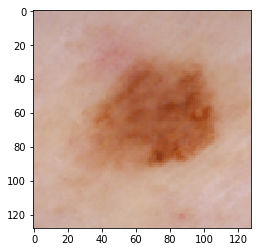

In [8]:
plt.imshow(test_img[0].permute(2,1,0))

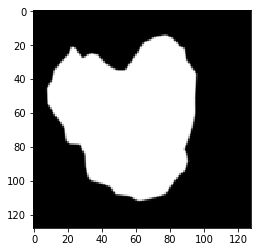

In [9]:
plt.imshow(test_lb[0].squeeze(),cmap = 'gray')

## Model

As a next step we create a UNet based model as shown in the figure below

![Unet](Images\Unet.jpg)

In [10]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2),
                        diffY // 2, int(diffY / 2)))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [11]:
class UNet_model(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet_model, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def weight_init(self):
        for i,m in enumerate(self.modules()):
            if isinstance(m,nn.Conv2d):
                nn.init.xavier_normal(m.weight)
                nn.init.constant(m.bias, 0)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = F.sigmoid(x)
        return x

In [12]:
model = UNet_model(3,1).cuda()
model.weight_init()

Now lets check if the model gives correct output

In [13]:
test_res  = model(test_img.cuda())

In [14]:
test_res.shape

torch.Size([2, 1, 128, 128])

## Dice Loss & Jaccard Index

Since we have the imbalance present in the data with lesion regions being small, we will try using Dice loss for optimizing the network


![Diceloss](Images/Diceloss.jpg)
Credit - https://www.jeremyjordan.me/semantic-segmentation/#loss

In [15]:
class DiceCoeffLoss(nn.Module):
    def __init__(self,smooth=1):
        super(DiceCoeffLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self,input, target):
        iflat = input.view(-1)
        tflat = target.view(-1)
        intersection = (iflat * tflat).sum()
        return 1 - ((2. * intersection + self.smooth) / (iflat.sum() + tflat.sum() + self.smooth))

In [16]:
criterion = DiceCoeffLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-5)

In [17]:
test_op = model(test_img.cuda())
criterion.forward(test_lb.cuda(),test_op)

tensor(0.6887, device='cuda:0', grad_fn=<AddBackward>)

As a next step we will use Intersection Over Union (IOU)/Jaccard Index as an evaluation metric.

In [18]:
from skimage.morphology import label as sk_label
from scipy.ndimage.filters import gaussian_filter

In [19]:
# Code adopted from https://github.com/yuanqing811/ISIC2018/blob/master/runs/seg_eval.py
def task1_post_process(y_prediction, threshold=0.5, gauss_sigma=0.):
    for im_index in range(y_prediction.shape[0]):
        # smooth image by Gaussian filtering
        if gauss_sigma > 0.:
            y_prediction[im_index] = gaussian_filter(input=y_prediction[im_index], sigma=gauss_sigma)
        thresholded_image = y_prediction[im_index] > threshold
        labels, num_labels = sk_label(thresholded_image, return_num=True)
        max_label_idx = -1
        max_size = 0
        for label_idx in range(0, num_labels + 1):
            if np.sum(thresholded_image[labels == label_idx]) == 0:
                continue
            current_size = np.sum(labels == label_idx)
            if current_size > max_size:
                max_size = current_size
                max_label_idx = label_idx
        if max_label_idx > -1:
            y_prediction[im_index] = labels == max_label_idx
        else: # no predicted pixels found
            y_prediction[im_index] = y_prediction[im_index] * 0
    return y_prediction

In [20]:
def jaccard(y_true, y_pred):
    intersect = np.sum(y_true * y_pred) # Intersection points
    union = np.sum(y_true) + np.sum(y_pred)  # Union points
    return (float(intersect))/(union - intersect +  1e-7)


def compute_jaccard(y_true, y_pred):

    mean_jaccard = 0.
    thresholded_jaccard = 0.

    for im_index in range(y_pred.shape[0]):

        current_jaccard = jaccard(y_true=y_true[im_index], y_pred=y_pred[im_index])

        mean_jaccard += current_jaccard
        thresholded_jaccard += 0 if current_jaccard < 0.65 else current_jaccard

    mean_jaccard = mean_jaccard/y_pred.shape[0]
    thresholded_jaccard = thresholded_jaccard/y_pred.shape[0]

    return mean_jaccard, thresholded_jaccard

## Training

Next we will train the NN for few epochs to check the convergence. Again more accuracy can be bought up by tuning the NN, using augementations etc

In [21]:
from tensorboardX import SummaryWriter
writer = SummaryWriter('runs_unet_mini')

In [22]:
niter = 0
niter_val = 0
for epoch in range(num_epochs):
    avg_mean_jaccard_train = []
    avg_mean_jaccard_val = []
    
    model.train()
    # Train
    train_loss = 0
    for i,(images,labels) in enumerate(train_loader):
        images = images.cuda()
        labels =labels.cuda()
        outputs = model(images)
        optimizer.zero_grad()
        loss = criterion.forward(labels,outputs)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        y_pred_post = task1_post_process(outputs.detach().cpu().numpy())
        mean_jaccard, thresholded_jaccard = compute_jaccard(y_true=labels.cpu().numpy(), y_pred=y_pred_post.squeeze(1))
        avg_mean_jaccard_train.append(mean_jaccard)
        del images,labels,outputs
        if i%5 == 0:
            print('Epoch [%d/%d], Step [%d/%d], Train Loss = %.4f' %(epoch+1, num_epochs, i+1, len(train_dataset)//bs, loss.data))
            writer.add_scalar('Train/Loss', loss.data, niter)
            niter+=5
            
    
    #Validate
    model.eval()
    val_loss = 0
    for j,(images,labels) in enumerate(val_loader):
        images = images.cuda()
        labels =labels.cuda()
        outputs = model(images)
        loss = criterion.forward(labels,outputs)
        val_loss += loss.item()
        y_pred_post = task1_post_process(outputs.detach().cpu().numpy())
        mean_jaccard, thresholded_jaccard = compute_jaccard(y_true=labels.cpu().numpy(), y_pred=y_pred_post.squeeze(1))
        avg_mean_jaccard_val.append(mean_jaccard)
        del images,labels,outputs
        if j%2 == 0:
            print('Epoch [%d/%d], Step [%d/%d], Val Loss = %.4f' %(epoch+1, num_epochs, j+1, len(val_dataset)//bs, loss.data))
            writer.add_scalar('Val/Loss', loss.data, niter_val)
            niter_val+=2
    
    
    print('Train Mean jaccard for Epoch is = %.3f ' % (np.mean(avg_mean_jaccard_train)))
    print('Epoch [%d/%d], Avg Train Loss = %.4f' %(epoch+1, num_epochs, train_loss/(i+1)))
    writer.add_scalar('Train/Epoch Jaccard Index', np.mean(avg_mean_jaccard_train), epoch)
    writer.add_scalar('Train/Average Loss', train_loss/(i+1), epoch)
    
    print('Val Mean jaccard for Epoch is = %.3f ' % (np.mean(avg_mean_jaccard_val)))
    print('Epoch [%d/%d], Avg Val Loss = %.4f' %(epoch+1, num_epochs, val_loss/(j+1)))
    writer.add_scalar('Val/Epoch Jaccard Index', np.mean(avg_mean_jaccard_val), epoch)
    writer.add_scalar('Val/Average Loss', val_loss/(j+1), epoch)

Epoch [1/100], Step [1/20], Train Loss = 0.6887
Epoch [1/100], Step [6/20], Train Loss = 0.7226
Epoch [1/100], Step [11/20], Train Loss = 0.6529
Epoch [1/100], Step [16/20], Train Loss = 0.3723
Epoch [1/100], Step [1/5], Val Loss = 0.7147
Epoch [1/100], Step [3/5], Val Loss = 0.5686
Epoch [1/100], Step [5/5], Val Loss = 0.3276
Train Mean jaccard for Epoch is = 0.514 
Epoch [1/100], Avg Train Loss = 0.5349
Val Mean jaccard for Epoch is = 0.336 
Epoch [1/100], Avg Val Loss = 0.5699
Epoch [2/100], Step [1/20], Train Loss = 0.3869
Epoch [2/100], Step [6/20], Train Loss = 0.7372
Epoch [2/100], Step [11/20], Train Loss = 0.6154
Epoch [2/100], Step [16/20], Train Loss = 0.3191
Epoch [2/100], Step [1/5], Val Loss = 0.4704
Epoch [2/100], Step [3/5], Val Loss = 0.3506
Epoch [2/100], Step [5/5], Val Loss = 0.1948
Train Mean jaccard for Epoch is = 0.566 
Epoch [2/100], Avg Train Loss = 0.4687
Val Mean jaccard for Epoch is = 0.514 
Epoch [2/100], Avg Val Loss = 0.4830
Epoch [3/100], Step [1/20], Tr

Epoch [34/100], Step [11/20], Train Loss = 0.1387
Epoch [34/100], Step [16/20], Train Loss = 0.2353
Epoch [34/100], Step [1/5], Val Loss = 0.3218
Epoch [34/100], Step [3/5], Val Loss = 0.1331
Epoch [34/100], Step [5/5], Val Loss = 0.4437
Train Mean jaccard for Epoch is = 0.664 
Epoch [34/100], Avg Train Loss = 0.1705
Val Mean jaccard for Epoch is = 0.420 
Epoch [34/100], Avg Val Loss = 0.4930
Epoch [35/100], Step [1/20], Train Loss = 0.1024
Epoch [35/100], Step [6/20], Train Loss = 0.0856
Epoch [35/100], Step [11/20], Train Loss = 0.0935
Epoch [35/100], Step [16/20], Train Loss = 0.1908
Epoch [35/100], Step [1/5], Val Loss = 0.2126
Epoch [35/100], Step [3/5], Val Loss = 0.1375
Epoch [35/100], Step [5/5], Val Loss = 0.4392
Train Mean jaccard for Epoch is = 0.713 
Epoch [35/100], Avg Train Loss = 0.1244
Val Mean jaccard for Epoch is = 0.436 
Epoch [35/100], Avg Val Loss = 0.4765
Epoch [36/100], Step [1/20], Train Loss = 0.0918
Epoch [36/100], Step [6/20], Train Loss = 0.0811
Epoch [36/10

Epoch [67/100], Step [16/20], Train Loss = 0.2032
Epoch [67/100], Step [1/5], Val Loss = 0.4297
Epoch [67/100], Step [3/5], Val Loss = 0.2089
Epoch [67/100], Step [5/5], Val Loss = 0.1993
Train Mean jaccard for Epoch is = 0.761 
Epoch [67/100], Avg Train Loss = 0.1042
Val Mean jaccard for Epoch is = 0.457 
Epoch [67/100], Avg Val Loss = 0.4613
Epoch [68/100], Step [1/20], Train Loss = 0.0829
Epoch [68/100], Step [6/20], Train Loss = 0.0720
Epoch [68/100], Step [11/20], Train Loss = 0.0890
Epoch [68/100], Step [16/20], Train Loss = 0.1747
Epoch [68/100], Step [1/5], Val Loss = 0.2003
Epoch [68/100], Step [3/5], Val Loss = 0.0835
Epoch [68/100], Step [5/5], Val Loss = 0.2270
Train Mean jaccard for Epoch is = 0.755 
Epoch [68/100], Avg Train Loss = 0.0988
Val Mean jaccard for Epoch is = 0.491 
Epoch [68/100], Avg Val Loss = 0.4308
Epoch [69/100], Step [1/20], Train Loss = 0.0943
Epoch [69/100], Step [6/20], Train Loss = 0.0722
Epoch [69/100], Step [11/20], Train Loss = 0.0568
Epoch [69/10

Epoch [100/100], Step [1/5], Val Loss = 0.3627
Epoch [100/100], Step [3/5], Val Loss = 0.0759
Epoch [100/100], Step [5/5], Val Loss = 0.3915
Train Mean jaccard for Epoch is = 0.823 
Epoch [100/100], Avg Train Loss = 0.0600
Val Mean jaccard for Epoch is = 0.435 
Epoch [100/100], Avg Val Loss = 0.4801


After we have trainined it for a few epochs we save/checkpoint the model

In [24]:
#saving model
torch.save(model.state_dict(),'Unet_mini.pth')

In [14]:
# load model
model.load_state_dict(torch.load('Unet_mini.pth'))

## Evaluation

We evaluate the model on Training as well as Test data

In [23]:
# Testing some Basic Traning Predictions
transforms=tfms.Compose([
    tfms.Resize((128,128)),
    tfms.ToTensor()
])
img_test = Image.open(r"Data/Segmentation/Images_train/ISIC_0000001.jpg")
img_test  = transforms(img_test)           
lb_test = Image.open(r"Data/Segmentation/Segmentations_train/ISIC_0000001_expert.png")
lb_test = transforms(lb_test)

In [24]:
# Helper function to display image
def display_prediction(img,true_label):
    seg_pred = model(img_test.unsqueeze(0).cuda())
    fig,axes = plt.subplots(nrows = 1,ncols=3,figsize = (10,10))
    axes[0].imshow(img.permute(1,2,0))
    axes[0].set_title('Image')
    axes[1].imshow(seg_pred[0].squeeze().detach(),cmap = 'gray')
    axes[1].set_title('Prediction')
    axes[2].imshow(true_label.squeeze(),cmap = 'gray')
    axes[2].set_title('Ground Truth')

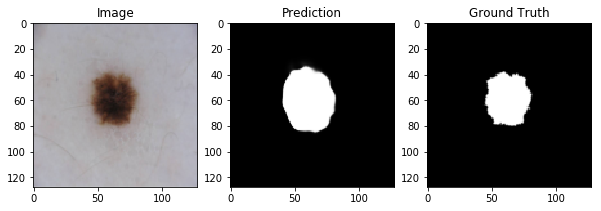

In [25]:
display_prediction(img_test,lb_test)

In [26]:
img_test = Image.open(r"Data/Segmentation/Images_train/ISIC_0000103.jpg")
img_test  = transforms(img_test)           
lb_test = Image.open(r"Data/Segmentation/Segmentations_train/ISIC_0000103_expert.png")
lb_test = transforms(lb_test)

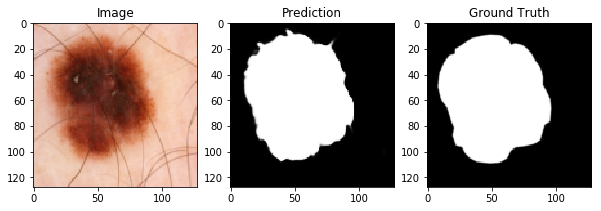

In [27]:
display_prediction(img_test,lb_test)

In [28]:
img_test = Image.open(r"Data/Segmentation/Images_train/ISIC_0000607.jpg")
img_test  = transforms(img_test)           
lb_test = Image.open(r"Data/Segmentation/Segmentations_train/ISIC_0000607_novice.png")
lb_test = transforms(lb_test)

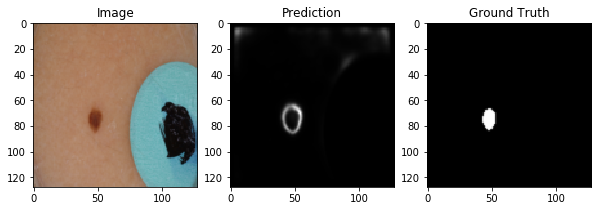

In [29]:
display_prediction(img_test,lb_test)

In [30]:
avg_mean_jaccard = []

In [31]:
for i,(images,labels) in enumerate(train_loader):
        print('Generating Stats for Batch - ' + str(i))
        images = images.cuda()
        y_pred = model(images)
        y_pred_post = task1_post_process(y_pred.detach().cpu().numpy())
        mean_jaccard, thresholded_jaccard = compute_jaccard(y_true=labels.numpy(), y_pred=y_pred_post.squeeze(1))
        avg_mean_jaccard.append(mean_jaccard)
        print('Mean jaccard = %.3f, Thresholded Jaccard = %.3f ' % (mean_jaccard, thresholded_jaccard))

Generating Stats for Batch - 0
Mean jaccard = 0.656, Thresholded Jaccard = 0.371 
Generating Stats for Batch - 1
Mean jaccard = 0.732, Thresholded Jaccard = 0.732 
Generating Stats for Batch - 2
Mean jaccard = 0.000, Thresholded Jaccard = 0.000 
Generating Stats for Batch - 3
Mean jaccard = 0.851, Thresholded Jaccard = 0.851 
Generating Stats for Batch - 4
Mean jaccard = 0.837, Thresholded Jaccard = 0.837 
Generating Stats for Batch - 5
Mean jaccard = 0.349, Thresholded Jaccard = 0.349 
Generating Stats for Batch - 6
Mean jaccard = 0.437, Thresholded Jaccard = 0.437 
Generating Stats for Batch - 7
Mean jaccard = 0.937, Thresholded Jaccard = 0.937 
Generating Stats for Batch - 8
Mean jaccard = 0.603, Thresholded Jaccard = 0.453 
Generating Stats for Batch - 9
Mean jaccard = 0.841, Thresholded Jaccard = 0.841 
Generating Stats for Batch - 10
Mean jaccard = 0.676, Thresholded Jaccard = 0.457 
Generating Stats for Batch - 11
Mean jaccard = 0.662, Thresholded Jaccard = 0.354 
Generating Sta

In [32]:
print('The Mean training Jaccard Index is = %.3f' % (np.mean(avg_mean_jaccard)))

The Mean training Jaccard Index is = 0.589


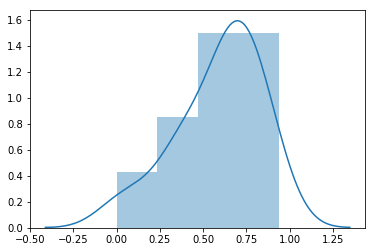

In [33]:
sns.distplot(pd.Series(avg_mean_jaccard))

In [34]:
test_dataset = SkinLesionDataLoader(r'Data/Segmentation/Images_test',
                                     r'Data/Segmentation/Segmentations_test/',
                                    transforms=tfms.Compose([tfms.Resize((128,128)),tfms.ToTensor()
                                                            ]))

In [35]:
val_loader = data.DataLoader(test_dataset,shuffle=False,batch_size=bs)

In [36]:
avg_mean_jaccard = []

In [37]:
for i,(images,labels) in enumerate(val_loader):
        print('Generating Stats for Batch - ' + str(i))
        images = images.cuda()
        y_pred = model(images)
        y_pred_post = task1_post_process(y_pred.detach().cpu().numpy())
        mean_jaccard, thresholded_jaccard = compute_jaccard(y_true=labels.numpy(), y_pred=y_pred_post.squeeze(1))
        avg_mean_jaccard.append(mean_jaccard)
        print('Mean jaccard = %.3f, Thresholded Jaccard = %.3f ' % (mean_jaccard, thresholded_jaccard))

Generating Stats for Batch - 0
Mean jaccard = 0.936, Thresholded Jaccard = 0.936 
Generating Stats for Batch - 1
Mean jaccard = 0.513, Thresholded Jaccard = 0.333 
Generating Stats for Batch - 2
Mean jaccard = 0.012, Thresholded Jaccard = 0.000 


The Mean training Jaccard Index is = 0.487


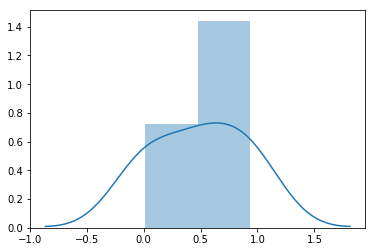

In [38]:
print('The Mean training Jaccard Index is = %.3f' % (np.mean(avg_mean_jaccard)))
sns.distplot(pd.Series(avg_mean_jaccard))

In [39]:
img_test = Image.open(r"Data/Segmentation/Images_test/ISIC_0000028.jpg")
img_test  = transforms(img_test)           
lb_test = Image.open(r"Data/Segmentation/Segmentations_test/ISIC_0000028_expert.png")
lb_test = transforms(lb_test)

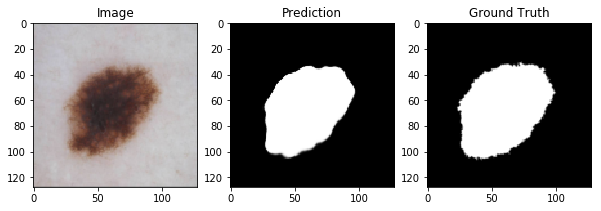

In [40]:
display_prediction(img_test,lb_test)

In [46]:
img_test = Image.open(r"Data/Segmentation/Images_test/ISIC_0001001.jpg")
img_test  = transforms(img_test)           
lb_test = Image.open(r"Data/Segmentation/Segmentations_test/ISIC_0001001_expert.png")
lb_test = transforms(lb_test)

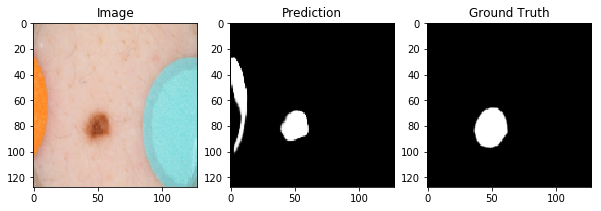

In [47]:
display_prediction(img_test,lb_test)